In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

# Оптимизация

[Black-Box Optimization Challenge, или как подбирать гиперпараметры для моделей](https://habr.com/ru/companies/hsespb/articles/537020/) (Дата обращения 29.03.2025)

# Гауссовский процесс

- [Регрессия гауссовского процесса с самого начала](https://habr.com/ru/companies/skillfactory/articles/562892/) (Дата обращения 29.03.2025)
- [\[DeepBayes\] День 4, лекция 2. Гауссовские процессы и байесовская оптимизация](https://youtu.be/PgJMLpIfIc8?si=Xkxg0Ndqox6NNqUp) (Дата обращения 29.03.2025)


Дано:
$$
\begin{align}
    & \mathbf{X} = \{x_1, ..., x_n\} \\
    & \mathbf{f} = \{f_{1}(x_1), ..., f_{n}(x_n)\} = \mathbf{y} = \{y_1, ..., y_n\} \\
\end{align}
$$

Обучение:
$$
\begin{align}
    & p(\mathbf{f}|\mathbf{X}) = \mathcal{N}(\mu, \mathbf{K}) \\
    & f(\mathbf{x}) \sim \mathcal{GP}(\mu(\mathbf{x}), k(\mathbf{x}, \mathbf{x}^{\prime})) \\
    & \mu(\mathbf{x}) = \mathbb{E}(f(\mathbf{x})) \\
    & k(\mathbf{x}, \mathbf{x}^{\prime}) = \mathbb{E}(f(\mathbf{x} - m(\mathbf{x}))f(\mathbf{x}^{\prime} - m(\mathbf{x}^{\prime}))) = cov(\mathbf{x}, \mathbf{x}^{\prime})=\sigma_{f}^{2}\exp\{-\sum_{i=1}^{d}\frac{(x_{i}-x_{i}^{\prime})^2}{2r_{i}^2}\}\text{ - rbf kernel}
\end{align}
$$

Предсказание:
$$
\begin{align}
    & y_* = f_{*}(\mathbf{x}_{*}) + \epsilon_{*} \\
    & p(\mathbf{y}, f_{*}) = \mathcal{N}\left(0, \left[ \begin{matrix} 
        \mathbf{K} + \sigma^2 I_m & \mathbf{k}_* \\ 
        \mathbf{k}_*^{\top} & \mathbf{K}_{**} 
    \end{matrix} \right]\right) \\
    & \mu_\ast = \mathbf{k}_\ast^\mathrm{T} [\mathbf{K} + \sigma^2 \mathbf{I}_m]^{-1} \mathbf{y}, \\
    & \sigma_\ast^2 = \bar{K}_{\ast\ast} - \mathbf{k}_\ast^\mathrm{T} [\mathbf{K} + \sigma^2 \mathbf{I}_m]^{-1} \mathbf{k}_\ast

\end{align}
$$

## Заметка

- [Коэффициент вариации](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%B8) (Дата обращения 30.03.2025)
- [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) (Дата обращения 30.03.2025)

При увеличении количества признаков точность предсказаний гауссовского процесса падет (это можно корректировать подбором коэффициента $r$, но не существенно). **Причина - проклятье размерности**. При увеличении признаков расстояние между объектами становится всё более одинаковым и, как следствие, rbf-ядро перестаёт работать. 

Рассмотрим вычисление евклидового расстояния $D^2=||x_i - x_j||^2 = \sum_{i,j=1}^d (x_i - x_j)^2$ между независимыми равномерно распределнными точками в d-мерном единичном кубе $[0, 1]^d$:
$$
\begin{align}
    & \mathbb{E}(D^2) = d\mathbb{E}((x_i - x_j)^2) = \frac{d}{6} \\
    & Var(D^2) = d Var((x_i - x_j)^2) = d (\mathbb{E}[(x_i - x_j)^4] - \mathbb{E}[(x_i - x_j)^2]^2) = \frac{d}{45} \\
    & CV = \frac{\sigma}{\mu} = \frac{6\sqrt{\frac{d}{45}}}{d} \rightarrow \lim_{d \rightarrow \infty}CV = 0
\end{align}
$$
Видно, что $CV$ (коэффициент вариации, показывающий изменчивость данных в выборке) стремится к 0 при увеличении размерности, то есть, действительно, евклидово расстояние для всех точек становится практически одинаковым. 

In [4]:
class GaussianProcess:
    def __init__(self, sigma=1, r=1, noise=0.1):
        self.sigma = sigma # Предполагаемое распределение
        self.r = r # Данный параметр масштабирует значения ковариационной функции
        self.noise = noise # Ввожу шум для борьбы с вырожденными ковариационными матрицами 

    def rbf_kernel(self, xi, xj, sigma=1.0, r=1.0):
        return sigma**2 * np.exp( -np.sum( (xi - xj)**2 / (2 * r**2) ) ) # Абсолютно гладкое гауссовское ядро
    
    def cov(self, X1, X2=None):
        if X2 is None:
            X2 = X1
        return np.array(
            [self.rbf_kernel(x1, x2, self.sigma, self.r) for x1 in X1 for x2 in X2]
        ).reshape( (len(X1), len(X2)) )
    
    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train) 
        return self

    def predict(self, X_test):
        X_test = np.array(X_test)
        K = self.cov(self.X_train) # Считаем ковариационные матрицы трейна с самим собой
        K_ss = self.cov(X_test) # Считаем ковариационные матрицы теста с самим собой
        K_s = self.cov(self.X_train, X_test) # Считаем ковариационные матрицы трейна и тестом
        K_inv = np.linalg.inv(K + self.noise**2 * np.eye(len(self.X_train))) # Обратная матрица с регуляризационным членом
        mu_s = K_s.T @ K_inv @ self.y_train # Предсказываем среднее
        cov_s = K_ss - K_s.T @ K_inv @ K_s # Предсказываем дисперсии
        return (mu_s, np.diag(cov_s))

In [5]:
X_GP, y_GP = make_regression(n_features=1)
X_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(X_GP, y_GP, test_size=0.1)

model_GP = GaussianProcess().fit(X_train_GP, y_train_GP)
mu, var = model_GP.predict(X_test_GP)

r2_score(y_test_GP, mu)

0.9511887008370439

# Функция приобретения

- [Acquisition functions in Bayesian Optimization](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html) (Дата обращения 30.03.2025)

Есть следующие варианты:
- **Expected Improvement (EI)** – ожидаемое улучшение.
$$
\begin{align}
    & \mathrm{EI}(x;\xi) = (\mu - f(x^*) - \xi)\,\Phi\left(\frac{\mu - f(x^*) - \xi}{\sigma}\right) + \sigma\,\varphi\left(\frac{\mu - f(x^*) - \xi}{\sigma}\right) \\
    & \Phi(x) - \mathrm{CDF}(x),\space \varphi(x) = \frac{1}{\sqrt{2\pi}}\exp(\frac{-x^2}{2})
\end{align}
$$
- **Probability of Improvement (PI)** – вероятность улучшения.
$$
\begin{align}
& \mathrm{PI}(x)=\Phi(\frac{\mu(x) - f(x^{*})}{\sigma(x)})
\end{align}
$$
- **Upper Confidence Bound (UCB)** – верхняя граница доверительного интервала.
$$
\begin{align}
& \mathrm{UCB}(x) = \mu(x) + \beta\sigma(x)
\end{align} 
$$

In [6]:
class AcquisitionFunc:
    def UCB(self, model_gp, x, b = 1):
        x = np.array([x])
        m, var = model_gp.predict(x)
        return -1*(m + b * var)

In [7]:
acq_func = AcquisitionFunc()
dots = acq_func.UCB(model_GP, [2])
mu[np.argmax(dots)], var[np.argmax(dots)]

(3.1059626717408286, 0.0004887317576717232)

# Объединение гауссового процесса и функции приобретения в байесовскую оптимизацию

Порядок работы алгоритма оптимизации:
1. Получение начальных значений оптимизируемой функции
2. Обучение на них гауссовского процесса
3. Максимизация (минимизация отрицательного значения) функции приобретения
4. Получение значения целевой функции в точке, полученной на предыдущем шаге
5. Переобучение гауссового процесса с учетом новой информации: точки максимизирующей функцию приобретения и значения на ней целевой функции

In [8]:
# Целевая функция
def custom_function(x):
    return -np.sin(x) * np.exp(-(x - 2)**2) + np.exp(-0.5 * (x + 2)**2)

X_sample = np.random.uniform(-5, 5, 5).reshape(-1, 1)
Y_sample = custom_function(X_sample)

# Обучение гауссовского процесса
gp = GaussianProcess(sigma=1, r=1, noise=0.1)
gp.fit(X_sample, Y_sample)

# Основной цикл байесовской оптимизации
for i in range(10):
    y_max = np.max(Y_sample) # Беру максимальный известный y (вообще можно взять любой, но вдруг попаду в максимум)
    result = minimize(AcquisitionFunc.UCB, x0=np.random.uniform(-5, 5), args=(gp, y_max), bounds=[(-5, 5)]) # Максимизирую функцию приобретения
    X_next = result.x

    Y_next = custom_function(X_next) # Оценить целевую функцию в новой точке

    # Добавляю известную точку к другим уже известным и заново учу гауссовский процесс
    X_sample = np.vstack((X_sample, X_next.reshape(1, -1))) 
    Y_sample = np.append(Y_sample, Y_next)
    gp.fit(X_sample, Y_sample)

    # Вывожу текущий максимум
    print(f"Y: {np.max(Y_sample)}, X: {X_sample[np.argmax(Y_sample)]}")

Y: 0.9997269363309992, X: [-1.97662371]
Y: 0.9997269363309992, X: [-1.97662371]
Y: 0.9997269363309992, X: [-1.97662371]
Y: 0.9997269363309992, X: [-1.97662371]
Y: 0.9997269363309992, X: [-1.97662371]
Y: 0.9997269363309992, X: [-1.97662371]
Y: 0.9997269363309992, X: [-1.97662371]
Y: 0.9997269363309992, X: [-1.97662371]
Y: 0.9997269363309992, X: [-1.97662371]
Y: 0.9997269363309992, X: [-1.97662371]


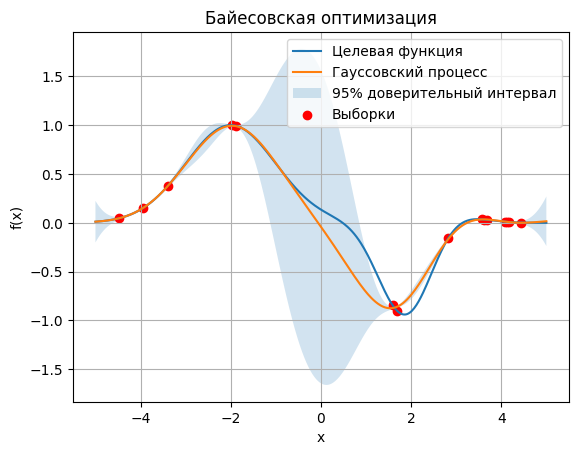

In [9]:
# Визуализация результатов
x_values = np.linspace(-5, 5, 400).reshape(-1, 1)
y_values = custom_function(x_values)
mu, sigma = gp.predict(x_values)

plt.plot(x_values, y_values, label='Целевая функция')
plt.plot(x_values, mu, label='Гауссовский процесс')
plt.fill_between(x_values.flatten(), mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, label='95% доверительный интервал')
plt.scatter(X_sample, Y_sample, color='red', label='Выборки')
plt.title('Байесовская оптимизация')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()

#  Теперь байесовскую оптимиазацию превращу в класс и приспособлю её для рабоы с моделя машинного обучения

Гиперпараметры для оптимизации будут задаваться в словаре, где каждый ключ - название гиперпараметра. Он хранит кортеж из двух элементов: 
- Тип данных.
- Интервал значений.

In [38]:
from sklearn.base import clone

class GaussianProcess:
    def __init__(self, sigma=1, r=1, noise=0.1):
        self.sigma = sigma # Предполагаемое распределение
        self.r = r # Данный параметр масштабирует значения ковариационной функции
        self.noise = noise # Ввожу шум для борьбы с вырожденными ковариационными матрицами 

    def rbf_kernel(self, xi, xj, sigma=1.0, r=1.0):
        return sigma**2 * np.exp( -np.sum( (xi - xj)**2) / (2 * r**2) ) # Абсолютно гладкое гауссовское ядро
    
    def cov(self, X1, X2=None):
        if X2 is None:
            X2 = X1
        return np.array(
            [self.rbf_kernel(x1, x2, self.sigma, self.r) for x1 in X1 for x2 in X2]
        ).reshape( (len(X1), len(X2)) )
    
    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train) 
        return self

    def predict(self, X_test):
        X_test = np.array(X_test)
        K = self.cov(self.X_train) # Считаем ковариационные матрицы трейна с самим собой
        K_ss = self.cov(X_test) # Считаем ковариационные матрицы теста с самим собой
        K_s = self.cov(self.X_train, X_test) # Считаем ковариационные матрицы трейна и тестом
        K_inv = np.linalg.inv(K + self.noise**2 * np.eye(len(self.X_train))) # Обратная матрица с регуляризационным членом
        mu_s = K_s.T @ K_inv @ self.y_train # Предсказываем среднее
        cov_s = K_ss - K_s.T @ K_inv @ K_s # Предсказываем дисперсии
        return (mu_s, np.diag(cov_s))

class AcquisitionFunc:
    def UCB(self, model_gp, X, b = 2):
        m, var = model_gp.predict(X.reshape(1, -1))
        return -1*(m + b * var)

class BayesOptimization:
    def __init__(self, model,
                       dict_params,
                       obj_func="GP",
                       acq_func="UCB",
                       n_iters=50,
                       cv=5):
        
        self.n_iters = n_iters
        self.cv = cv
        self.obj_func = obj_func
        self.acq_func = acq_func  
        self.model = model
        self.dict_params = dict_params

    def fit(self, X, y):
        number_of_starting_points = 10
        X_sample, Y_sample = [], []
        for point in range(number_of_starting_points): 
            # Задаём каким образом генерирутся оптимизируемые параметры для модели
            uniform_func = np.random.uniform
            # Здесь хранятся случайные значения для оптимизируемых параметров
            optimization_params = {}
            nums_for_params = []
            for key, param in self.dict_params.items(): 
                # Тип переменной
                type_func = param[0]
                # Интервал
                a, b = param[1]
                # Генерация значения гиперпараметра
                num = type_func(uniform_func(a, b))
                optimization_params[key] = num
                nums_for_params.append(num)
            # Кросс-валидация с сгенерированными параметрами 
            model = clone(self.model).set_params(**optimization_params)
            cv_results = cross_validate(model.set_params(**optimization_params),
                                        X, y)
            # Запоминаем новую стартовую точку
            X_sample.append(nums_for_params)
            Y_sample.append(np.mean(cv_results["test_score"]))
        # Перевожу в np массив
        X_sample = np.array(X_sample)
        Y_sample = np.array(Y_sample)
        # Обучение гауссовского процесса
        gp = GaussianProcess(sigma=1, r=1, noise=0.1)
        gp.fit(X_sample, Y_sample)
        # Основной цикл байесовской оптимизации
        for i in range(self.n_iters):
            # Беру максимальный известный y (вообще можно взять любой, но вдруг попаду в максимум)
            y_max = np.max(Y_sample)
            # Генерирую начальные точки для минимизации
            X0 = []
            bounds = []
            for key, param in self.dict_params.items(): 
                # Тип параметра
                type_func = param[0]
                # Интервал
                a, b = param[1]
                # Генерация значения гиперпараметра
                X0.append(type_func(uniform_func(a, b)))
                bounds.append((a, b))
            # Максимизирую функцию приобретения
            result = minimize(AcquisitionFunc.UCB, 
                              x0=X0, 
                              args=(gp, y_max), 
                              bounds=bounds, 
                              method='L-BFGS-B')
            # Следующие X
            X_next = result.x
            # Здесь хранятся значения новой точки для оптимизируемых параметров
            optimization_params = {}
            i = 0
            for key, param in self.dict_params.items(): 
                # Тип переменной
                type_func = param[0]
                # Приводим значения гиперпараметра к нужному типу
                num = type_func(X_next[i])
                optimization_params[key] = num
                i += 1
            # Кросс-валидация с сгенерированными параметрами 
            model = clone(self.model).set_params(**optimization_params)
            cv_results = cross_validate(model, X, y)
            # Оценить целевую функцию в новой точке
            Y_next = np.mean(cv_results["test_score"])
            # Добавляю известную точку к другим уже известным и заново учу гауссовский процесс
            X_sample = np.vstack((X_sample, X_next.reshape(1, -1))) 
            Y_sample = np.append(Y_sample, Y_next)
            gp.fit(X_sample, Y_sample)
        # Лучший score
        best_score = np.max(Y_sample)
        # Лучший набор параметров
        best_params_value = X_sample[np.argmax(Y_sample)]
        best_params = {}
        i = 0
        for key in self.dict_params: 
            best_params[key] = best_params_value[i]
            i += 1

        return best_score, best_params

# Модель для теста оптимизации

In [119]:
X, y = make_classification(n_informative=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
tree = DecisionTreeClassifier().fit(X_train, y_train)
print(f"Cross validation score: {np.mean(cross_val_score(tree, X_test, y_test))}")

Cross validation score: 0.45


In [120]:
tree_params = {'max_depth': (int, [1, 100]), "min_samples_leaf": (int, [1, 100]), "min_samples_split": (int, [2, 100])}
score, params = BayesOptimization(tree, tree_params, n_iters=10).fit(X, y)
print(f"best score: {score}")
print(f"best params: {params}")


best score: 0.82
best params: {'max_depth': 40.0, 'min_samples_leaf': 32.0, 'min_samples_split': 59.0}
